In [17]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from IPython.display import Image

(1)

In [18]:
data = np.loadtxt('./rand_points.txt')
x = data[:,0]
y = data[:,1]
z = data[:,2]

In [19]:
%matplotlib widget

# creating figure
fig = plt.figure()

ax = plt.axes(projection='3d')
ax.plot(x, y, z, '.', markersize = 3)
plt.show()

# displaying the plot
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

I'm not sure if the jupyter notebook will keep track of the view of the interactive plot above. So I took a snapshot to show below. We can indeed see distinct planes, and there are around 30 of them!

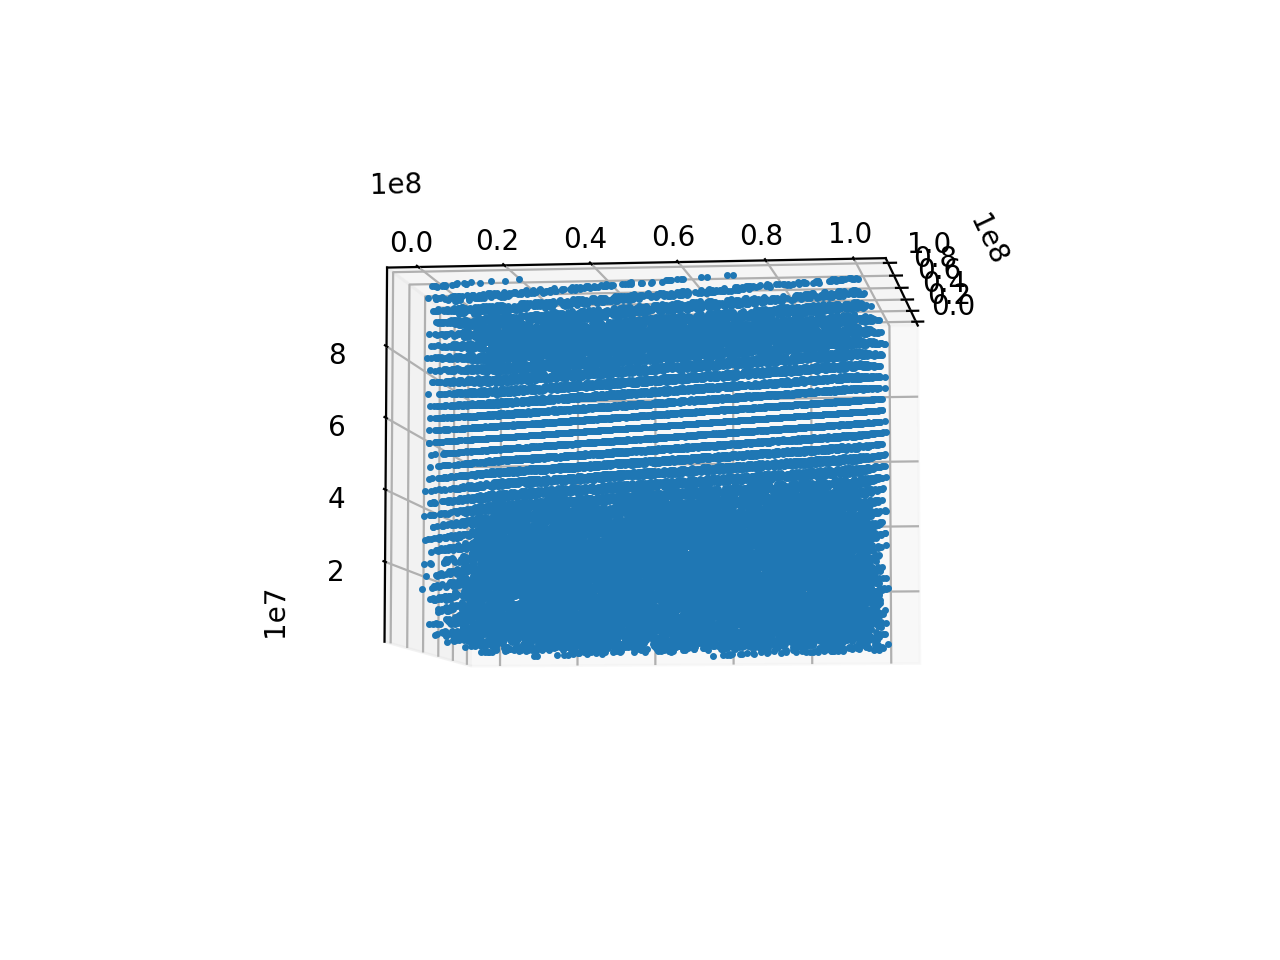

In [20]:
Image(filename="./Figure 1.png", width=800, height=800)

Try the same thing with python's integer generator (I will stick to sampling between $0, 10^8$).

In [40]:
N = int(len(x))
rng = np.random.default_rng()
rints = rng.integers(low=0,high=int(1e8), size=[N,3])
print(np.shape(rints))
new_x = rints[:,0]
new_y = rints[:,1]
new_z = rints[:,2]

(30253, 3)


In [41]:
%matplotlib widget

# creating figure
fig = plt.figure()

ax = plt.axes(projection='3d')
ax.plot(new_x, new_y, new_z, '.', markersize = 3)
plt.show()

# displaying the plot
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

After playing with the view angle for quite some time, I was not able to discover any obvious patterns (I could not spot any planes on which the numbers lie, for example).

Next, try running Jon's script locally on my machine and see if the plane-like behaviour persists. I just changed the name of the output file in the script to a different name and then run the script inline using the command below.

In [42]:
exec(open("./test_broken_libc.py").read())

In [43]:
data = np.loadtxt('./rand_points_new.txt')
x = data[:,0]
y = data[:,1]
z = data[:,2]

%matplotlib widget

# creating figure
fig = plt.figure()

ax = plt.axes(projection='3d')
ax.plot(x, y, z, '.', markersize = 3)
plt.show()

# displaying the plot
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

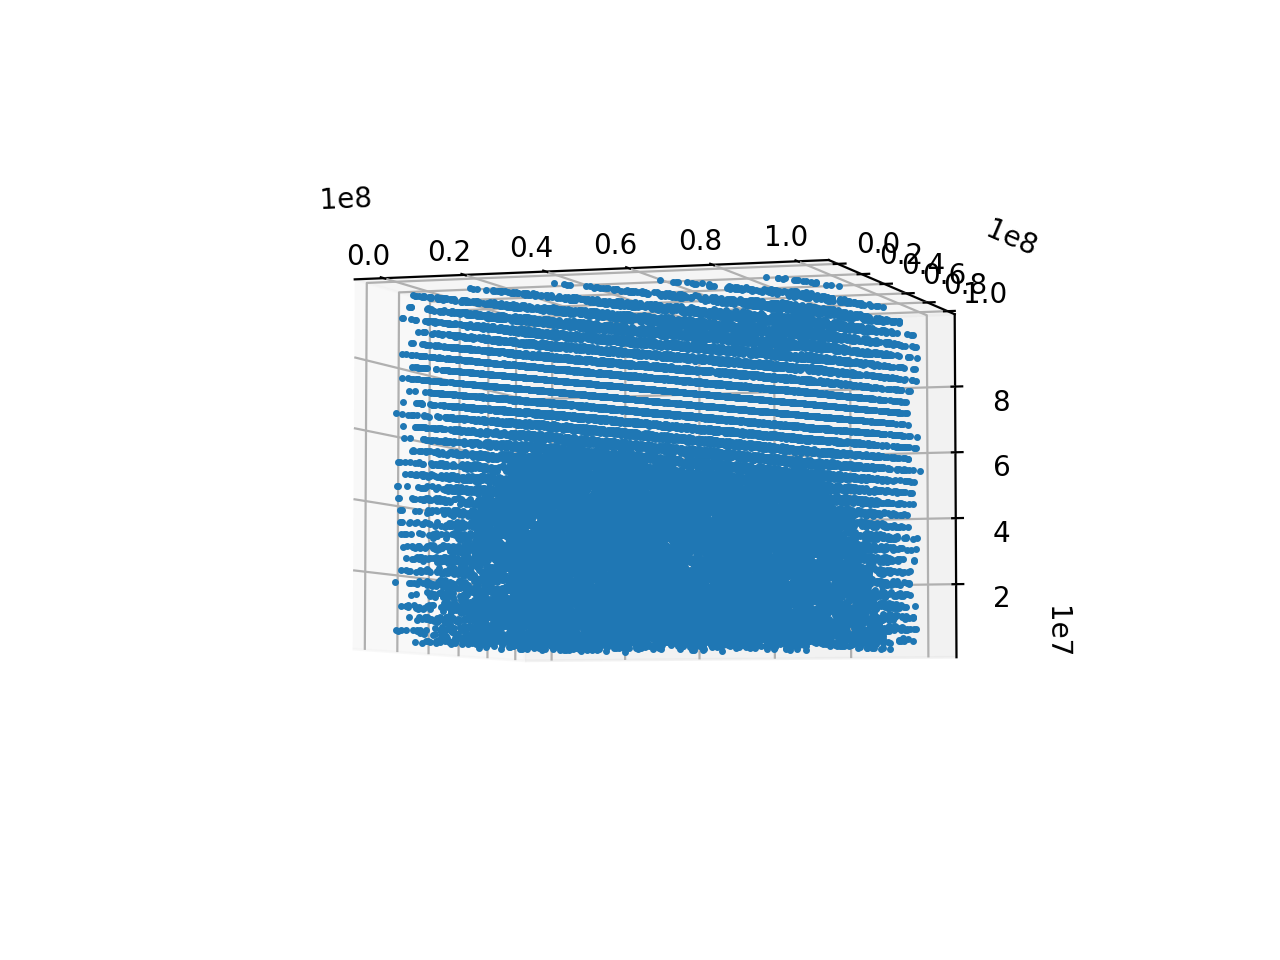

In [44]:
Image(filename="./Figure 1-2.png", width=800, height=800)

Yet again, I see about 30 planes (put in a snapshot as before in case jupyter refuses to save my view settings), so I can confirm that I can reproduce this behaviour locally on my machine.

(2) First let's plot the distributions with respect to the exponential distribution to see which of these is greater than $e^{-x}$ for all $x$.

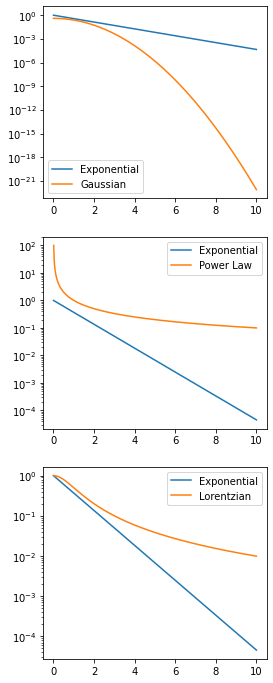

In [133]:
def lorentzian(x,a=1.0):
    return 1/(1+(x**2/a**2))

def gaussian(x,sig = 1.0):
    return np.exp(-x**2/(2*sig**2))/np.sqrt(2*np.pi*sig**2)

def power_law(x, alpha = 1.0):
    return x**(alpha)

def exponential(x, tau = 1.0):
    return np.exp(-x/tau)

x = np.linspace(0,10,1001)

lorentz = lorentzian(x)
gauss = gaussian(x,sig = 1.)
power = power_law(x[1:],alpha = -1.0)
expo = exponential(x, tau=1.0)

plt.rcParams['figure.figsize'] = (4,12)
fig, axs = plt.subplots(3,1)
ax0 = axs[0]
ax1 = axs[1]
ax2 = axs[2]

ax0.semilogy(x, expo, label = 'Exponential')
ax0.semilogy(x, gauss, label = 'Gaussian')
ax0.legend()

ax1.semilogy(x, expo, label = 'Exponential')
ax1.semilogy(x[1:], power, label = 'Power Law')
ax1.legend()

ax2.semilogy(x, expo, label = 'Exponential')
ax2.semilogy(x, lorentz, label = 'Lorentzian')
ax2.legend()


plt.show()

Both the Lorentzian and the power law distribution satisfy the upper bound property. However, since I would like to include $x=0$ in my sampling, I cannot use the power law distribution! 

However, I can use the Lorentzian to sample from the exponential distribution for all $x \geq 0$ since the Lorentzian is bounded as well as greater than the exponential distribution for all $x \geq 0$. For the rejection method, normalizing either distribution is unnecessary. For the CDF of the lorentzian, we have, for $x \geq 0$:

$\text{CDF}_L = \frac{\int_{0}^{x} L(y) dy}{\int_{0}^{\infty} L(y) dy} = \frac{\int_{0}^{x} \frac{dy}{1+y^2}}{\int_{0}^{\infty} \frac{dy}{1+y^2}} = \frac{\tan^{-1}(x)}{\tan^{-1}(\infty)} = \frac{2}{\pi}{\tan^{-1}(x)} $

$ \implies x = \tan(\frac{\pi}{2} r)$, where $r$ is a uniform random number $\in [0,1]$.

The plan is to draw some samples $r \in \text{Unif}[0,1]$, convert them to exponential deviates using the formula above, and sample an equal number $ g(x(r)) \in \text{Unif}[0,L(x)]$ and whenever $g(x) \leq e^{-x}$ accept the corresponding $x$ as a deviate. The notation $g(x(r))$ is to denote that there is one sample in the required range for each $x$ that is obtained via sampling $r$.

Efficiency:  0.63639


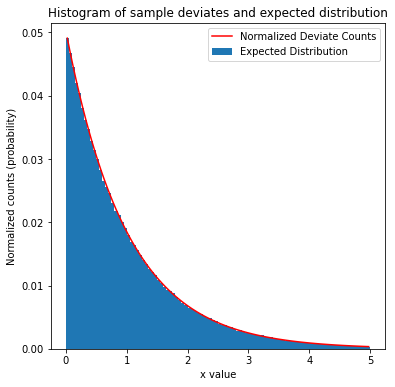

In [134]:
N = int(1e6)
r = np.random.rand(N)
y = np.tan(np.pi*r/2)

g = np.random.rand(N) * lorentzian(y)

accept = g<=np.exp(-y)
print("Efficiency: ", np.mean(accept))
x_use = y[accept]

plt.rcParams['figure.figsize'] = (6,6)
aa,bb=np.histogram(x_use,np.linspace(0,5,101))
b_cent=0.5*(bb[1:]+bb[:-1])
pred=np.exp(-b_cent)
pred=pred/pred.sum()
aa=aa/aa.sum()
plt.figure(2)
plt.clf()
plt.plot(b_cent,pred, c='r', label='Normalized Deviate Counts')
plt.bar(b_cent,aa,0.05, label = 'Expected Distribution')
plt.xlabel("x value")
plt.ylabel("Normalized counts (probability)")
plt.title("Histogram of sample deviates and expected distribution")
plt.legend()
plt.show()

To maximize efficiency, we can introduce a parameter '$a$' to the Lorentzian distribution: $L(x) = \frac{1}{1+\frac{x^2}{a^2}}$, and choose $a$ such that this curve is as close to the exponential as possible while still being greater than it for all $x \geq 0$.

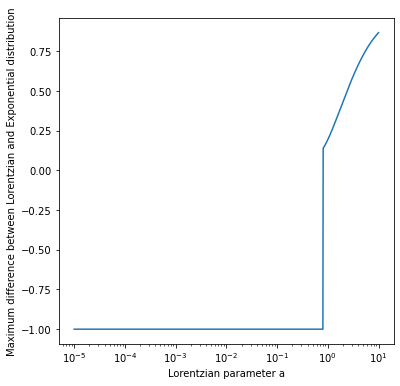

In [158]:
Na = 1001
a_array = np.linspace(1e-5, 10, Na)
max_diff = np.zeros(Na)
x = np.linspace(0,100,10001)
for i in range(Na):
    if np.min(lorentzian(x,a_array[i]) - exponential(x)) >= 0:
        max_diff[i] = np.max(lorentzian(x,a_array[i]) - exponential(x))
    else:
        max_diff[i] = -1

plt.semilogx(a_array, max_diff)
plt.xlabel("Lorentzian parameter a")
plt.ylabel("Maximum difference between Lorentzian and Exponential distribution")
plt.show()

In the plot above, any values of $-1$ imply that the lorentzian with that value of parameter $a$ is smaller than the exponential distribution at some point and so we cannot use this for sampling. Of the $a$-values where the corresponding max difference is positive, it appears that $a=1$ results in a lorentzian that is closest to the exponential (so the difference in areas would be smallest and the efficiency would be highest). Therefore, using the Lorentzian to sample has the maximum efficiency of $~0.6364$ from above.

(3) Here we would need to properly normalize the exponential distribution, but this is rather trivial since:

$\int_{x=0}^{\infty} e^{-y} dy = 1$ so it is already normalized.

We would like to sample pairs of points $(u,v) \in R^2$ such that $ 0 \leq u \leq \sqrt{p\left(\frac{v}{u}\right)} $. So, we should sample $u$ such that $0 \leq u \leq 1$, i.e. $u$ is uniform random and $ u^2 \leq p\left(\frac{v}{u}\right) \implies u^2 \leq e^-{\frac{v}{u}} \implies v \leq - 2u \ln{u}$. Let's plot the RHS of the last inequality as a function of $u$.

Maximum v value:  0.735758842423273
Minimum v value:  -0.0
Bounds on v:  0.0  <= v <=  0.735758842423273


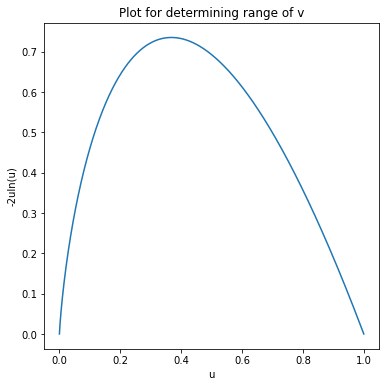

In [159]:
x = np.linspace(1e-6,1,2001)  # -2uln(u) equals zero at u=0, but python can't figure that out
f = -2 * x * np.log(x)
upper_lim = np.max(f)
lower_lim = np.min(f)
print("Maximum v value: ", upper_lim)
print("Minimum v value: ", lower_lim)
print("Bounds on v: ", np.abs(lower_lim), " <= v <= ", upper_lim)
plt.plot(x,f)
plt.xlabel("u")
plt.ylabel("-2uln(u)")
plt.title("Plot for determining range of v")
plt.show()

Thus,e have $ 0 \leq v \leq 0.7357...$ . So we draw samples $u \in \text{Unif}[0,1], v \in \text{Unif}[0,0.7357...]$. If $u < \sqrt{e^{- \frac{v}{u}}}$, return $\frac{v}{u}$ as the deviate, else reject the sample.

Fraction of accepted samples:  0.67952


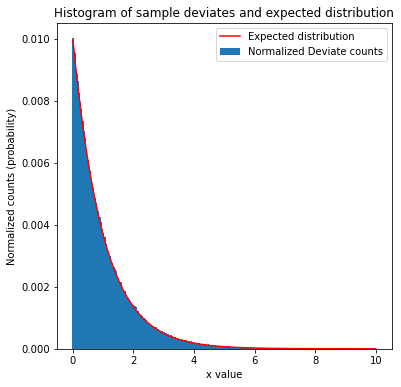

In [128]:
N = int(1e6)

u = np.random.rand(N)

# add a small numer to upper_lim to make sure that we don't lose samples because of round-off error
# if we don't add that number, results still make sense
# but efficiency -> ~ 0.678572 so it is a negligible difference

v = np.random.rand(N) * (upper_lim * (1+1e-15))

accept = u <= np.sqrt(np.exp(-v/u))
r = v/u
expo_sample = r[accept]

print("Fraction of accepted samples: ", np.mean(accept))
a,b=np.histogram(expo_sample,1000,range=(0,10))
bb=0.5*(b[1:]+b[:-1])
pred=np.exp(-bb)
pred=pred/np.sum(pred)
a = a/np.sum(a)
plt.figure(2)
plt.clf()
plt.bar(bb,a,0.05, label = 'Normalized Deviate counts')
plt.plot(bb,pred,'r', label = 'Expected distribution')
plt.xlabel("x value")
plt.ylabel("Normalized counts (probability)")
plt.title("Histogram of sample deviates and expected distribution")
plt.legend()
plt.show()

As it turns out, the ratio of uniforms method is atleast ~ 4.xx% more efficient than sampling from the Lorentzian distribution.